### SART EEG: aperiodic 1/f-like activity + band power analysis
Spectral analysis using Welch's PSD estimation, fitting the spectra to model to estimate aperiodic compoenent of the spectra (i.e. exponent and offset). After that, flatten the spectra (i.e. substact aperiodic component from the spectra) to calculate alpha power peak and center frequency and alpha band power (relative and absolute).

In [1]:
# Import packages
import os, mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fooof import FOOOF
from fooof.plts.spectra import plot_spectrum, plot_spectrum_shading

# Set default directory
os.chdir('/Users/tanijarv/Documents/GitHub/EEG-pyline')

# Import functions
import signal_processing.spectral_analysis as spectr
import basic.arrange_data as arrange

Define these variables!

In [67]:
# Folder where to get the clean epochs files
clean_folder = 'Data/Clean/'

# Folder where to save the results
results_folder = 'Results/'

# Sub-folder for the experiment (i.e. timepoint or group) and its acronym
exp_folder = 'LEISURE/T1/SART'
exp_condition = 'SART_T1'

# Brain regions and their channels
#brain_regions = {'Cz' : ['Cz']}
ch = 'Cz'

# brain_regions = {'Frontal midline' : ['Fz'],
#                  'Central midline' : ['Cz'],
#                  'Parietal midline' : ['Pz']}

# Power spectra estimation parameters
psd_params = dict(method='welch', fminmax=[1, 30], window='hamming', window_duration=1,
                  window_overlap=0, zero_padding=3, tminmax=[0, 1])

# FOOOF (specparam) model parameters
fooof_params = dict(peak_width_limits=[1,12], max_n_peaks=float('inf'), min_peak_height=0.225,
                    peak_threshold=2.0, aperiodic_mode='fixed')

# Band power of interest
bands = {'Theta' : [4, 8]}

# Flattened spectra amplitude scale (linear, log)
flat_spectr_scale = 'linear'

# Plot more information on the model fit plots or not; and save these plots or not
plot_rich = True
savefig = False

# Event names (i.e. different stimuli) within the epochs
event_list = ['GO trial', 'NO-GO trial']

Run this to set the folders for data.

In [68]:
# Get directories of clean EEG files and set export directory
dir_inprogress = os.path.join(clean_folder, exp_folder)
file_dirs, subject_names = arrange.read_files(dir_inprogress, "_clean-epo.fif")

Files in Data/Clean/LEISURE/T1/SART read in: 4


In [59]:
epochs['GO trial']

Number of events,474
Events,GO trial: 474
Time range,-0.200 – 1.000 sec
Baseline,off


Run this to analyse the EEG signal in the frequency domain (i.e. do spectral analysis) using Welch's PSD method and fitting the spectra to FOOOF (specparam) model to estimate aperiodic component of the signal, export this and also remove the aperiodic component to flatten the spectrum and calculate alpha peak parameters and powers.

GO trial for HBA_0001_SART_T1 (1/4)
---
PSD (welch) calculation

<Power Spectrum (from Epochs, welch method) | 475 epochs × 32 channels × 117 freqs, 1.0-30.0 Hz>
Time period: [0, 1]
Window type: hamming
Window size: 1024
Overlap: 0
Zero-padding: 3072

Samples per segment: 1024
Samples for FFT: 4096
Frequency resolution: 0.25 Hz
---
PSD (welch) calculation

<Power Spectrum (from Evoked, welch method) | 1 channels × 117 freqs, 1.0-30.0 Hz>
Time period: [0, 1]
Window type: hamming
Window size: 1024
Overlap: 0
Zero-padding: 3072

Samples per segment: 1024
Samples for FFT: 4096
Frequency resolution: 0.25 Hz


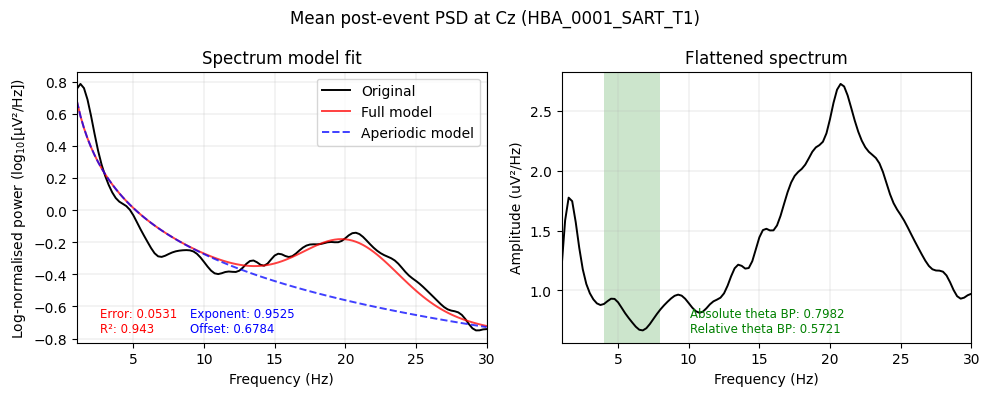

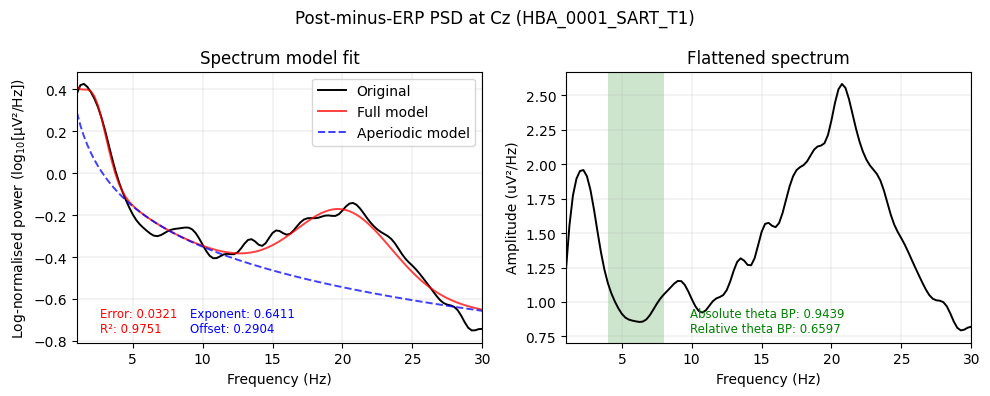

NO-GO trial for HBA_0001_SART_T1 (1/4)
---
PSD (welch) calculation

<Power Spectrum (from Epochs, welch method) | 55 epochs × 32 channels × 117 freqs, 1.0-30.0 Hz>
Time period: [0, 1]
Window type: hamming
Window size: 1024
Overlap: 0
Zero-padding: 3072

Samples per segment: 1024
Samples for FFT: 4096
Frequency resolution: 0.25 Hz
---
PSD (welch) calculation

<Power Spectrum (from Evoked, welch method) | 1 channels × 117 freqs, 1.0-30.0 Hz>
Time period: [0, 1]
Window type: hamming
Window size: 1024
Overlap: 0
Zero-padding: 3072

Samples per segment: 1024
Samples for FFT: 4096
Frequency resolution: 0.25 Hz


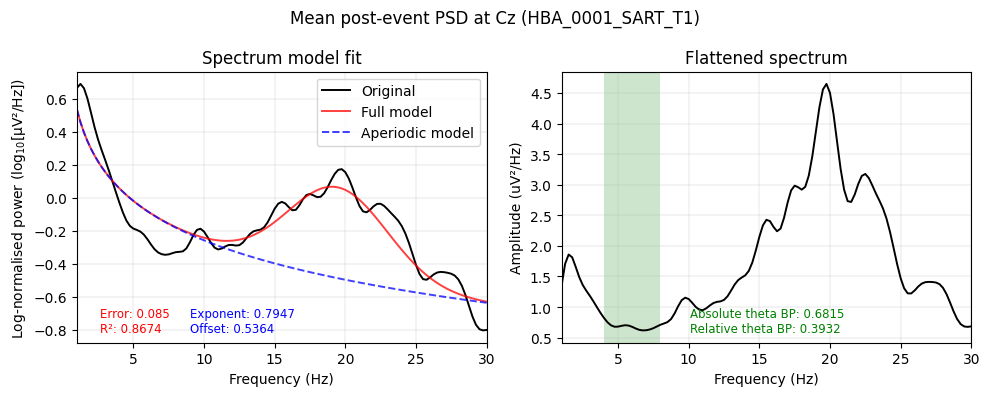

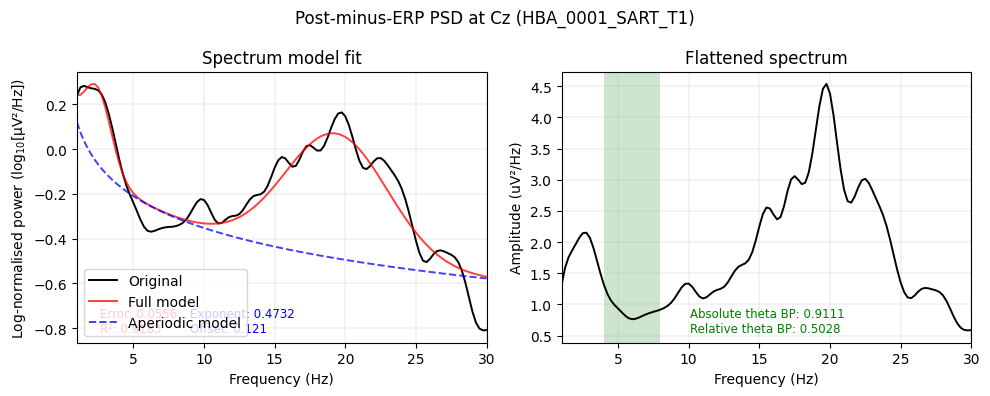

GO trial for HBA_0003_SART_T1 (2/4)
---
PSD (welch) calculation

<Power Spectrum (from Epochs, welch method) | 26 epochs × 32 channels × 117 freqs, 1.0-30.0 Hz>
Time period: [0, 1]
Window type: hamming
Window size: 1024
Overlap: 0
Zero-padding: 3072

Samples per segment: 1024
Samples for FFT: 4096
Frequency resolution: 0.25 Hz
---
PSD (welch) calculation

<Power Spectrum (from Evoked, welch method) | 1 channels × 117 freqs, 1.0-30.0 Hz>
Time period: [0, 1]
Window type: hamming
Window size: 1024
Overlap: 0
Zero-padding: 3072

Samples per segment: 1024
Samples for FFT: 4096
Frequency resolution: 0.25 Hz


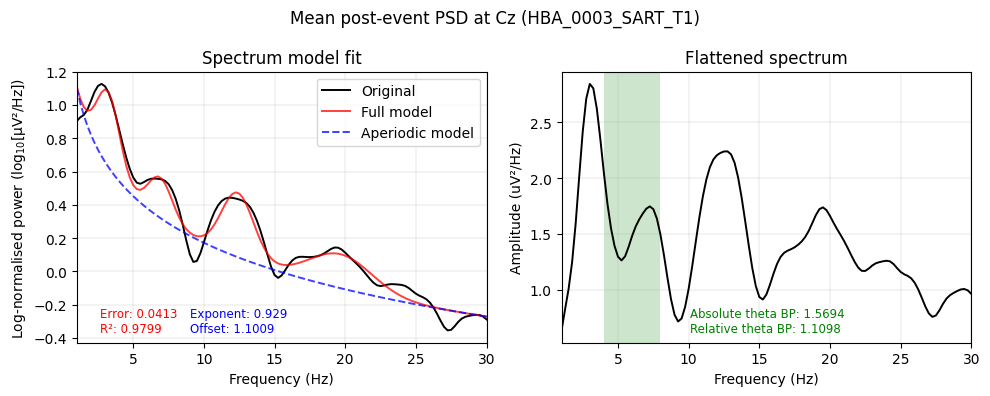

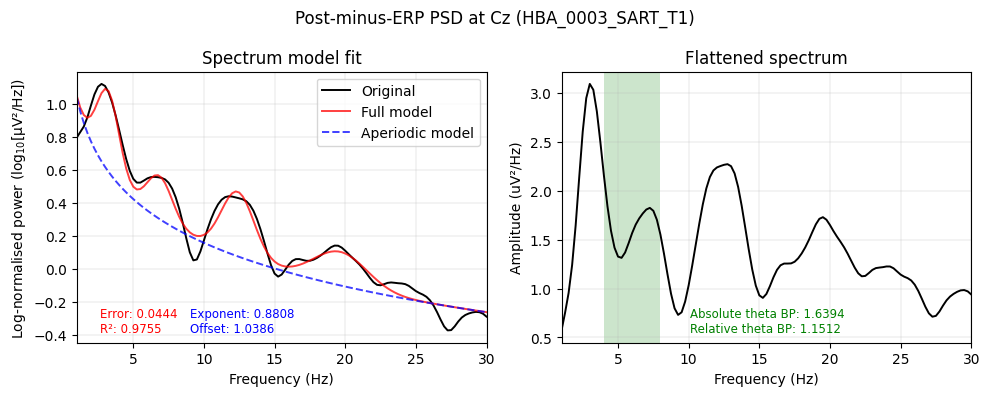

NO-GO trial for HBA_0003_SART_T1 (2/4)
---
PSD (welch) calculation

<Power Spectrum (from Epochs, welch method) | 56 epochs × 32 channels × 117 freqs, 1.0-30.0 Hz>
Time period: [0, 1]
Window type: hamming
Window size: 1024
Overlap: 0
Zero-padding: 3072

Samples per segment: 1024
Samples for FFT: 4096
Frequency resolution: 0.25 Hz
---
PSD (welch) calculation

<Power Spectrum (from Evoked, welch method) | 1 channels × 117 freqs, 1.0-30.0 Hz>
Time period: [0, 1]
Window type: hamming
Window size: 1024
Overlap: 0
Zero-padding: 3072

Samples per segment: 1024
Samples for FFT: 4096
Frequency resolution: 0.25 Hz


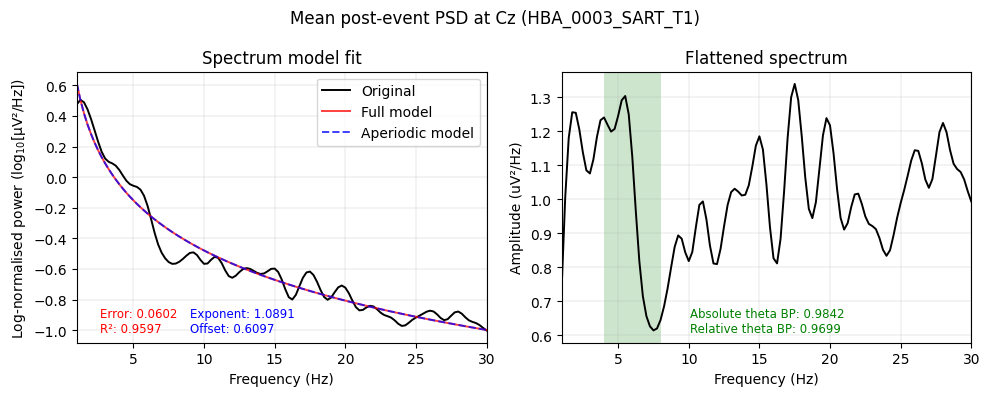

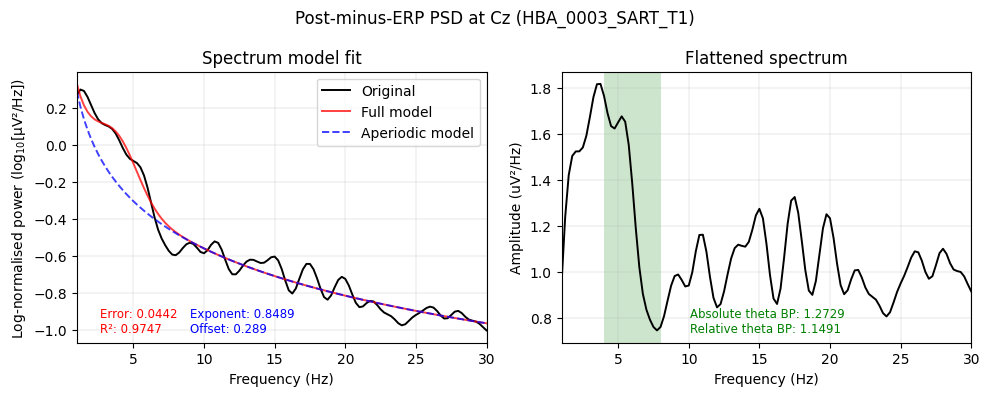

GO trial for HBA_0004_SART_T1 (3/4)
---
PSD (welch) calculation

<Power Spectrum (from Epochs, welch method) | 435 epochs × 32 channels × 117 freqs, 1.0-30.0 Hz>
Time period: [0, 1]
Window type: hamming
Window size: 1024
Overlap: 0
Zero-padding: 3072

Samples per segment: 1024
Samples for FFT: 4096
Frequency resolution: 0.25 Hz
---
PSD (welch) calculation

<Power Spectrum (from Evoked, welch method) | 1 channels × 117 freqs, 1.0-30.0 Hz>
Time period: [0, 1]
Window type: hamming
Window size: 1024
Overlap: 0
Zero-padding: 3072

Samples per segment: 1024
Samples for FFT: 4096
Frequency resolution: 0.25 Hz


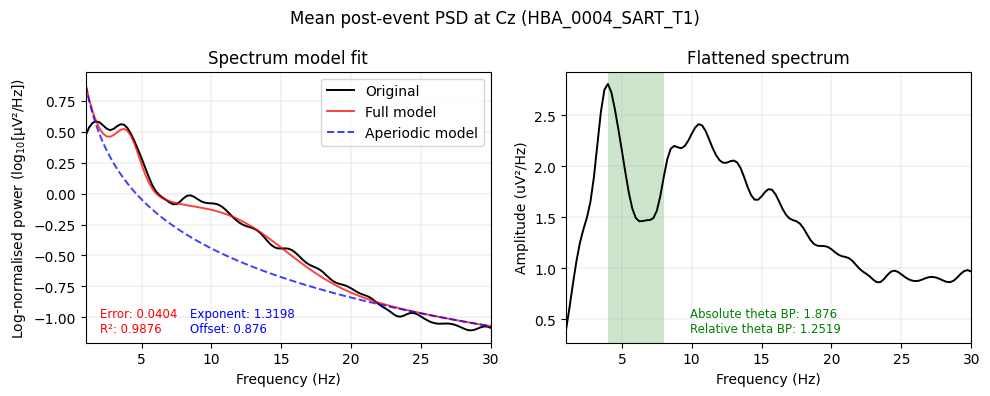

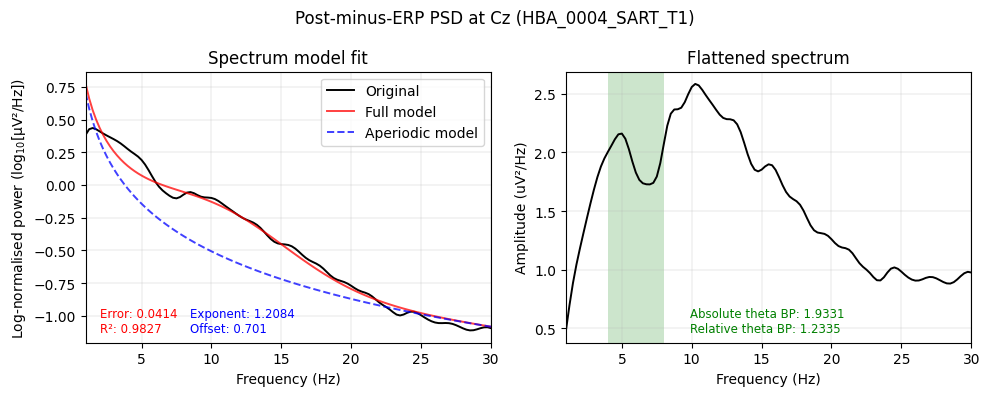

NO-GO trial for HBA_0004_SART_T1 (3/4)
---
PSD (welch) calculation

<Power Spectrum (from Epochs, welch method) | 35 epochs × 32 channels × 117 freqs, 1.0-30.0 Hz>
Time period: [0, 1]
Window type: hamming
Window size: 1024
Overlap: 0
Zero-padding: 3072

Samples per segment: 1024
Samples for FFT: 4096
Frequency resolution: 0.25 Hz
---
PSD (welch) calculation

<Power Spectrum (from Evoked, welch method) | 1 channels × 117 freqs, 1.0-30.0 Hz>
Time period: [0, 1]
Window type: hamming
Window size: 1024
Overlap: 0
Zero-padding: 3072

Samples per segment: 1024
Samples for FFT: 4096
Frequency resolution: 0.25 Hz


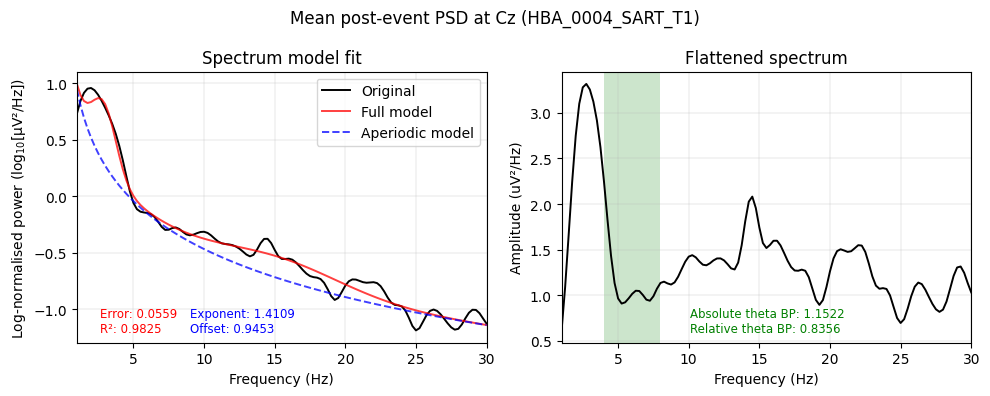

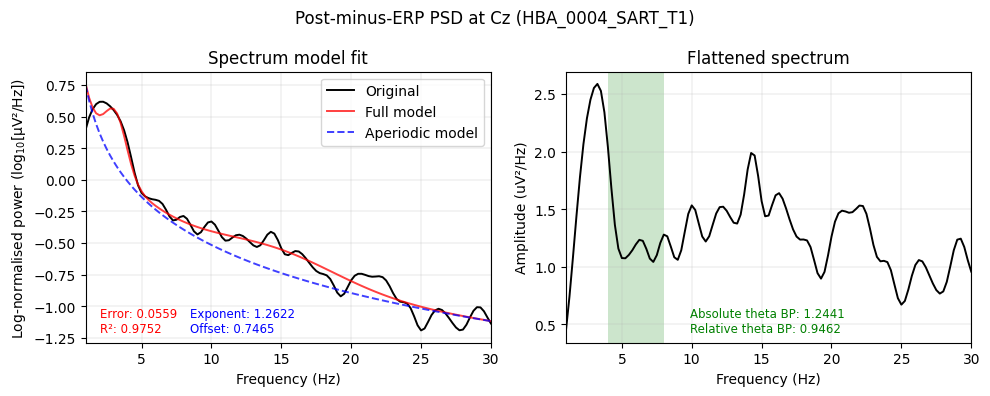

GO trial for HBA_0005_SART_T1 (4/4)
---
PSD (welch) calculation

<Power Spectrum (from Epochs, welch method) | 474 epochs × 32 channels × 117 freqs, 1.0-30.0 Hz>
Time period: [0, 1]
Window type: hamming
Window size: 1024
Overlap: 0
Zero-padding: 3072

Samples per segment: 1024
Samples for FFT: 4096
Frequency resolution: 0.25 Hz
---
PSD (welch) calculation

<Power Spectrum (from Evoked, welch method) | 1 channels × 117 freqs, 1.0-30.0 Hz>
Time period: [0, 1]
Window type: hamming
Window size: 1024
Overlap: 0
Zero-padding: 3072

Samples per segment: 1024
Samples for FFT: 4096
Frequency resolution: 0.25 Hz


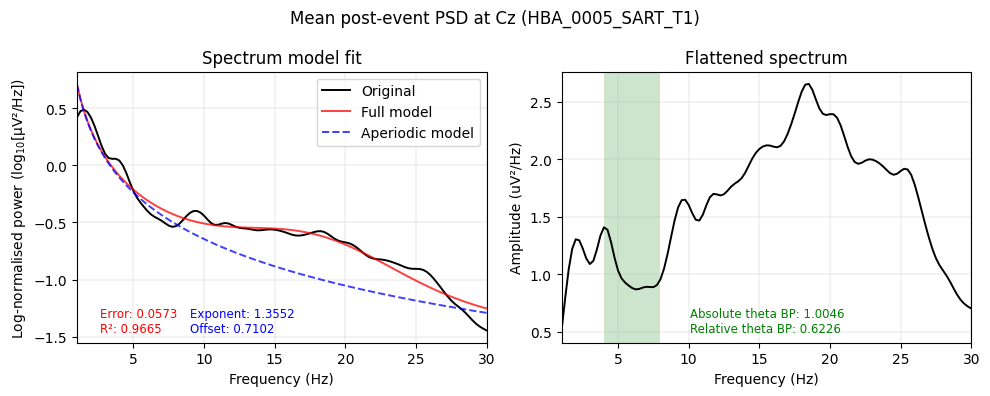

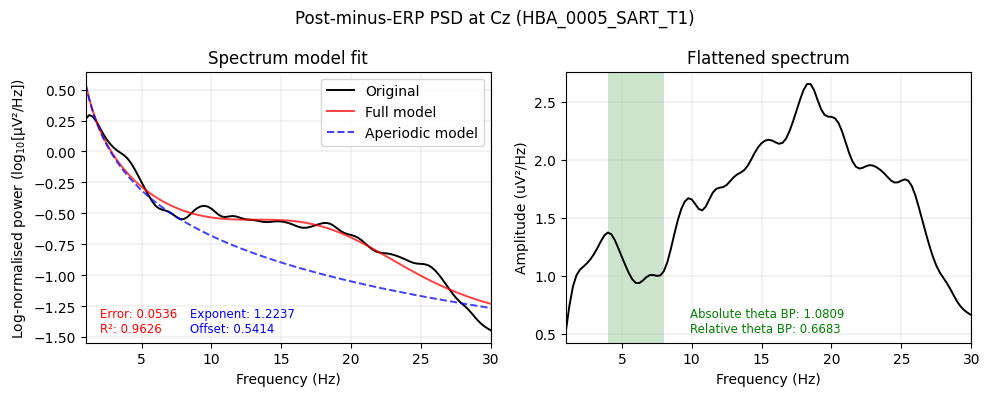

NO-GO trial for HBA_0005_SART_T1 (4/4)
---
PSD (welch) calculation

<Power Spectrum (from Epochs, welch method) | 56 epochs × 32 channels × 117 freqs, 1.0-30.0 Hz>
Time period: [0, 1]
Window type: hamming
Window size: 1024
Overlap: 0
Zero-padding: 3072

Samples per segment: 1024
Samples for FFT: 4096
Frequency resolution: 0.25 Hz
---
PSD (welch) calculation

<Power Spectrum (from Evoked, welch method) | 1 channels × 117 freqs, 1.0-30.0 Hz>
Time period: [0, 1]
Window type: hamming
Window size: 1024
Overlap: 0
Zero-padding: 3072

Samples per segment: 1024
Samples for FFT: 4096
Frequency resolution: 0.25 Hz


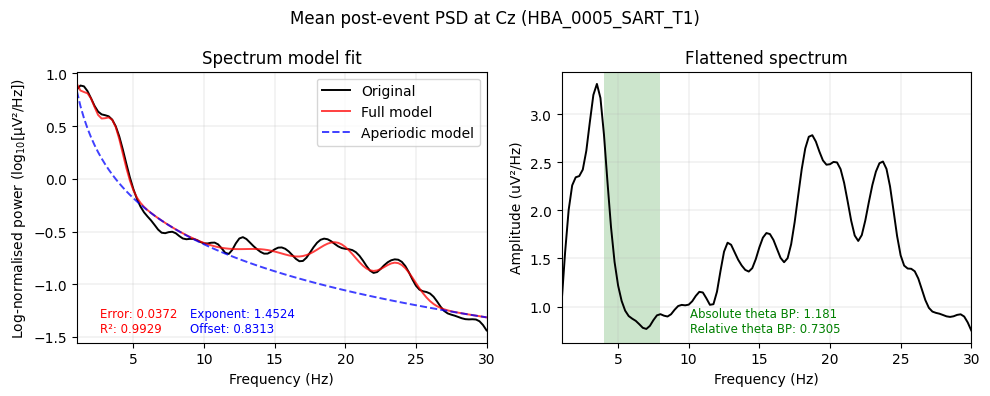

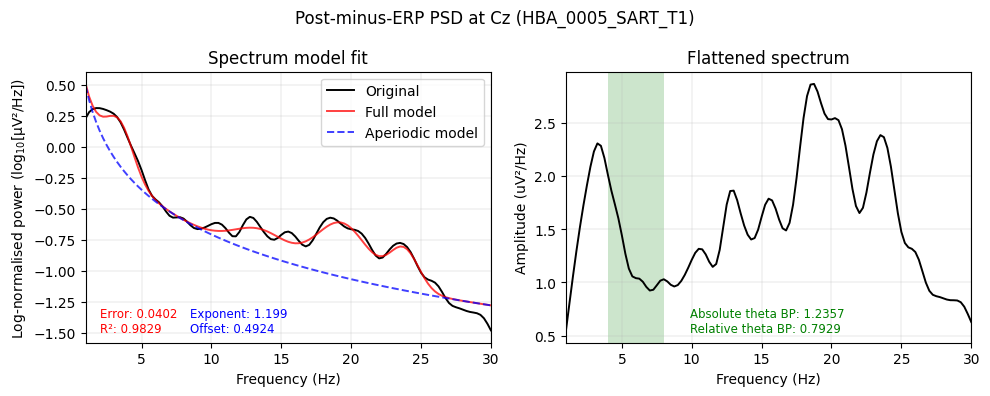

,Subject,Channel,Type,Event,Exponent,Offset,Theta absolute power,Theta relative power,R_2,Error
0,HBA_0001_SART_T1,Cz,Mean post-event,GO trial,0.952515,0.678362,0.798249,0.572130,0.942984,0.053126
1,HBA_0001_SART_T1,Cz,Post-minus-ERP,GO trial,0.641110,0.290382,0.943892,0.659717,0.975080,0.032066
2,HBA_0001_SART_T1,Cz,Mean post-event,NO-GO trial,0.794714,0.536370,0.681521,0.393223,0.867382,0.085004
3,HBA_0001_SART_T1,Cz,Post-minus-ERP,NO-GO trial,0.473159,0.120982,0.911089,0.502779,0.918255,0.055593
4,HBA_0003_SART_T1,Cz,Mean post-event,GO trial,0.929034,1.100868,1.569444,1.109823,0.979900,0.041326
5,HBA_0003_SART_T1,Cz,Post-minus-ERP,GO trial,0.880776,1.038606,1.639431,1.151241,0.975494,0.044424
6,HBA_0003_SART_T1,Cz,Mean post-event,NO-GO trial,1.089061,0.609667,0.984167,0.969874,0.959682,0.060182
7,HBA_0003_SART_T1,Cz,Post-minus-ERP,NO-GO trial,0.848903,0.288984,1.272946,1.149077,0.974678,0.044151
8,HBA_0004_SART_T1,Cz,Mean post-event,GO trial,1.319772,0.875967,1.875952,1.251896,0.987585,0.040364
9,HBA_0004_SART_T1,Cz,Post-minus-ERP,GO trial,1.208355,0.701034,1.933138,1.233524,0.982694,0.041424


In [146]:
# Pre-create results folders and dataframe
arrange.create_results_folders(exp_folder=exp_folder, results_folder=results_folder, fooof=True)
df_ch = pd.DataFrame()
# Go through all the files (subjects) in the folder
for i in range(len(file_dirs)):
    # Read the clean data from the disk
    epochs = mne.read_epochs(fname='{}/{}_clean-epo.fif'.format(dir_inprogress, subject_names[i]),
                                                                verbose=False)

    # Loop through all different events
    df_ch_ev = pd.DataFrame()
    df_ch_ev_diff = pd.DataFrame()
    for ev in event_list:
        print('{} for {} ({}/{})'.format(ev, subject_names[i], i+1, len(file_dirs)))

        ### POST-EVENT PSD ESTIMATION

        # Choose only epochs from the current event
        epochs_ev = epochs[ev]

        # Calculate Welch's power spectrum density (FFT) for the mean post-event
        [psds, freqs] = spectr.calculate_psd(epochs_ev, subject_names[i], **psd_params, verbose=True, plot=False)
        
        # Average all epochs and channels together -> (freq bins,) shape
        if i == 0:
            psds_allch = np.zeros(shape=(len(file_dirs), len(freqs)))
        psds_allch[i] = psds.mean(axis=(0, 1))

        # Average all epochs together for each channel and also for each region
        psds = psds.mean(axis=(0))
        df_psds_ch = arrange.array_to_df(subject_names[i], epochs_ev, psds).\
                            reset_index().drop(columns='Subject')

        # Choose only channel of interest data
        psds_temp = df_psds_ch[ch].to_numpy()

        ### ERP & POST-minus-ERP PSD ESTIMATIONS

        # Average the event epochs in time domain
        evoked_ev = epochs_ev.average(picks=ch)

        # Calculate Welch's power spectrum density (FFT) for the ERP
        [psds_erp, freqs] = spectr.calculate_psd(evoked_ev, subject_names[i], **psd_params, verbose=True, plot=False)

        # Calculate the post-minus-ERP PSD subtracting ERP PSD from post-event PSD
        psds_diff_ch = psds_temp - psds_erp[0]

        ### SPECPARAM

        # Fit the spectrums with FOOOF
        fm = FOOOF(**fooof_params, verbose=True)
        fm.fit(freqs, psds_temp, psd_params['fminmax'])
        fm_diff = FOOOF(**fooof_params, verbose=True)
        fm_diff.fit(freqs, psds_diff_ch, psd_params['fminmax'])
            
        # Log-linear conversion based on the chosen amplitude scale
        if flat_spectr_scale == 'linear':
            flatten_spectrum = 10 ** fm._spectrum_flat
            flatten_spectrum_diff = 10 ** fm_diff._spectrum_flat
            flat_spectr_ylabel = 'Amplitude (uV\u00b2/Hz)'
        elif flat_spectr_scale == 'log':
            flatten_spectrum = fm._spectrum_flat
            flatten_spectrum_diff = fm_diff._spectrum_flat
            flat_spectr_ylabel = 'Log-normalised amplitude'

        # Find individual alpha band parameters
        abs_bp, rel_bp = spectr.find_bp(flatten_spectrum, freqs, bands['Theta'])
        abs_bp_diff, rel_bp_diff = spectr.find_bp(flatten_spectrum_diff, freqs, bands['Theta'])

        ### PLOTTING

        # Set plot styles
        data_kwargs = {'color' : 'black', 'linewidth' : 1.4, 'label' : 'Original'}
        model_kwargs = {'color' : 'red', 'linewidth' : 1.4, 'alpha' : 0.75, 'label' : 'Full model'}
        aperiodic_kwargs = {'color' : 'blue', 'linewidth' : 1.4, 'alpha' : 0.75,
                            'linestyle' : 'dashed', 'label' : 'Aperiodic model'}
        flat_kwargs = {'color' : 'black', 'linewidth' : 1.4}
        hvline_kwargs = {'color' : 'blue', 'linewidth' : 1.0, 'linestyle' : 'dashed', 'alpha' : 0.75}
        
        # Plot power spectrum model + aperiodic fit for MEAN POST-EVENT PSD
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=100)
        plot_spectrum(fm.freqs, fm.power_spectrum,
                    ax=axs[0], plot_style=None, **data_kwargs)
        plot_spectrum(fm.freqs, fm.fooofed_spectrum_,
                    ax=axs[0], plot_style=None, **model_kwargs)
        plot_spectrum(fm.freqs, fm._ap_fit,
                    ax=axs[0], plot_style=None, **aperiodic_kwargs)
        axs[0].set_xlim(psd_params['fminmax'])
        axs[0].grid(linewidth=0.2)
        axs[0].set_xlabel('Frequency (Hz)')
        axs[0].set_ylabel('Log-normalised power (log$_{10}$[µV\u00b2/Hz])')
        axs[0].set_title('Spectrum model fit')
        axs[0].legend()
        
        # Flattened spectrum plot (i.e., minus aperiodic fit)
        plot_spectrum_shading(fm.freqs, flatten_spectrum,
                    ax=axs[1], shades=bands['Theta'], shade_colors='green',
                    plot_style=None, **flat_kwargs)
        #axs[1].vlines(bands['Theta'], ymin=axs[1].get_ylim()[0], ymax=axs[1].get_ylim()[1])
        axs[1].set_xlim(psd_params['fminmax'])
        axs[1].grid(linewidth=0.2)
        axs[1].set_xlabel('Frequency (Hz)')
        axs[1].set_ylabel(flat_spectr_ylabel)
        axs[1].set_title('Flattened spectrum')

        # If true, plot all the exported variables on the plots
        if plot_rich == True:
            axs[0].annotate('Error: ' + str(np.round(fm.get_params('error'), 4)) +
                        '\nR\u00b2: ' + str(np.round(fm.get_params('r_squared'), 4)),
                        (0.1, 0.16), xycoords='figure fraction', color='red', fontsize=8.5)
            axs[0].annotate('Exponent: ' + str(np.round(fm.get_params('aperiodic_params','exponent'), 4)) +
                        '\nOffset: ' + str(np.round(fm.get_params('aperiodic_params','offset'), 4)),
                        (0.19, 0.16), xycoords='figure fraction', color='blue', fontsize=8.5)
            axs[1].annotate('Absolute theta BP: '+str(np.round(abs_bp, 4))+'\nRelative theta BP: '+str(np.round(rel_bp, 4)),
                            (0.69, 0.16), xycoords='figure fraction', color='green', fontsize=8.5)
        
        plt.suptitle('Mean post-event PSD at {} ({})'.format(ch, subject_names[i]))
        plt.tight_layout()
        if savefig == True:
            plt.savefig(fname='{}/{}/FOOOF/{}_{}_{}_mean_post_event_PSD.png'.format(results_folder, exp_folder,
                                                                        exp_condition, subject_names[i],
                                                                        ch), dpi=300)
        plt.show()

        # Plot power spectrum model + aperiodic fit for POST-minus-ERP PSD
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=100)
        plot_spectrum(fm_diff.freqs, fm_diff.power_spectrum,
                    ax=axs[0], plot_style=None, **data_kwargs)
        plot_spectrum(fm_diff.freqs, fm_diff.fooofed_spectrum_,
                    ax=axs[0], plot_style=None, **model_kwargs)
        plot_spectrum(fm_diff.freqs, fm_diff._ap_fit,
                    ax=axs[0], plot_style=None, **aperiodic_kwargs)
        axs[0].set_xlim(psd_params['fminmax'])
        axs[0].grid(linewidth=0.2)
        axs[0].set_xlabel('Frequency (Hz)')
        axs[0].set_ylabel('Log-normalised power (log$_{10}$[µV\u00b2/Hz])')
        axs[0].set_title('Spectrum model fit')
        axs[0].legend()
        
        # Flattened spectrum plot (i.e., minus aperiodic fit)
        plot_spectrum_shading(fm_diff.freqs, flatten_spectrum_diff,
                    ax=axs[1], shades=bands['Theta'], shade_colors='green',
                    plot_style=None, **flat_kwargs)
        #axs[1].vlines(bands['Theta'], ymin=axs[1].get_ylim()[0], ymax=axs[1].get_ylim()[1])
        axs[1].set_xlim(psd_params['fminmax'])
        axs[1].grid(linewidth=0.2)
        axs[1].set_xlabel('Frequency (Hz)')
        axs[1].set_ylabel(flat_spectr_ylabel)
        axs[1].set_title('Flattened spectrum')

        # If true, plot all the exported variables on the plots
        if plot_rich == True:
            axs[0].annotate('Error: ' + str(np.round(fm_diff.get_params('error'), 4)) +
                        '\nR\u00b2: ' + str(np.round(fm_diff.get_params('r_squared'), 4)),
                        (0.1, 0.16), xycoords='figure fraction', color='red', fontsize=8.5)
            axs[0].annotate('Exponent: ' + str(np.round(fm_diff.get_params('aperiodic_params','exponent'), 4)) +
                        '\nOffset: ' + str(np.round(fm_diff.get_params('aperiodic_params','offset'), 4)),
                        (0.19, 0.16), xycoords='figure fraction', color='blue', fontsize=8.5)
            axs[1].annotate('Absolute theta BP: '+str(np.round(abs_bp_diff, 4))+'\nRelative theta BP: '+str(np.round(rel_bp_diff, 4)),
                            (0.69, 0.16), xycoords='figure fraction', color='green', fontsize=8.5)
        
        plt.suptitle('Post-minus-ERP PSD at {} ({})'.format(ch, subject_names[i]))
        plt.tight_layout()
        if savefig == True:
            plt.savefig(fname='{}/{}/FOOOF/{}_{}_{}_post_minus_erp_PSD.png'.format(results_folder, exp_folder,
                                                                        exp_condition, subject_names[i],
                                                                        ch), dpi=300)
        plt.show()

        ### EXPORTING

        # Add model parameters to dataframe for mean post-event
        df_ch_ev.loc[i, 'Exponent'] = fm.get_params('aperiodic_params','exponent')
        df_ch_ev.loc[i, 'Offset'] = fm.get_params('aperiodic_params','offset')
        df_ch_ev.loc[i, '{} absolute power'.format(list(bands.keys())[0])] = abs_bp
        df_ch_ev.loc[i, '{} relative power'.format(list(bands.keys())[0])] = rel_bp
        df_ch_ev.loc[i, 'R_2'] = fm.get_params('r_squared')
        df_ch_ev.loc[i, 'Error'] = fm.get_params('error')
        df_ch_ev['Channel'] = ch
        df_ch_ev['Event'] = ev
        df_ch_ev['Type'] = 'Mean post-event'
        df_ch_ev['Subject'] = subject_names[i]

        # Concatenate to master dataframe for mean post-event
        df_ch = pd.concat([df_ch, df_ch_ev])

        # Add model parameters to dataframe for post-minus-erp
        df_ch_ev_diff.loc[i, 'Exponent'] = fm_diff.get_params('aperiodic_params','exponent')
        df_ch_ev_diff.loc[i, 'Offset'] = fm_diff.get_params('aperiodic_params','offset')
        df_ch_ev_diff.loc[i, '{} absolute power'.format(list(bands.keys())[0])] = abs_bp_diff
        df_ch_ev_diff.loc[i, '{} relative power'.format(list(bands.keys())[0])] = rel_bp_diff
        df_ch_ev_diff.loc[i, 'R_2'] = fm_diff.get_params('r_squared')
        df_ch_ev_diff.loc[i, 'Error'] = fm_diff.get_params('error')
        df_ch_ev_diff['Channel'] = ch
        df_ch_ev_diff['Event'] = ev
        df_ch_ev_diff['Type'] = 'Post-minus-ERP'
        df_ch_ev_diff['Subject'] = subject_names[i]

        # Concatenate to master dataframe for post-minus-erp
        df_ch = pd.concat([df_ch, df_ch_ev_diff])
        

# Reorder the channels and reset index
df_ch = df_ch[['Subject', 'Channel', 'Type', 'Event', 'Exponent', 'Offset',
               '{} absolute power'.format(list(bands.keys())[0]),
               '{} relative power'.format(list(bands.keys())[0]),
               'R_2', 'Error']]
df_ch = df_ch.reset_index(drop=True)

# Export results for post-event data
df_ch.to_excel('{}/{}/FOOOF/{}_{}_specparam.xlsx'.format(results_folder, exp_folder, exp_condition, ch))
display(df_ch)

In [137]:
# evoked_ev = epochs_ev.average(picks=ch)

# [psds_erp, freqs_erp] = spectr.calculate_psd(evoked_ev, subject_names[i], **psd_params, verbose=True, plot=False)

# psds_diff_ch = psds_temp - psds_erp[0]

---
PSD (welch) calculation

<Power Spectrum (from Evoked, welch method) | 1 channels × 117 freqs, 1.0-30.0 Hz>
Time period: [0, 1]
Window type: hamming
Window size: 1024
Overlap: 0
Zero-padding: 3072

Samples per segment: 1024
Samples for FFT: 4096
Frequency resolution: 0.25 Hz
